# Twitterでフォロワーをクラスタリングしてみた。
---
データ収集

### 使うライブラリ
networkx, pandas, matplotlib

## 目次
- クラスタリングに必要なデータとは、
- クラスタリングをするために必要な手順（ライブラリや、データ整形など）
- 結果見る
- 結果をDB情報から引っ張ってきてさらにみて見る。
- 結果を元に、クラスタの属性分析をする方向性を固める。
    - 今のところ、自己紹介文を使って、tf-idfで処理し、属性を表す単語をピックアップする予定。
- 属性分析

## クラスタリングに必要なデータとは。
簡単にまとめると、  
ノードとエッジのみ。

今回の場合は、  
ノード = フォロワー（twitterユーザー）  
エッジ = 繋がりの関係（誰が誰をフォローしているのかということ）

ちょっとしたデモやる

In [1]:
import os, sys
sys.path.append('..')

import json
import time
import random
from tqdm import tqdm

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## クラスタリングをするために必要な手順（ライブラリや、データ整形など）
__ライブラリ__  
ライブラリは前述したものを参考に。  

__データ__  
- twitterのuser_idをひとまず、ノードの判別に利用する。
- フォロワーがフォローしているユーザー群を持ってきて、フォロワーに含まれるuser_idを取得  

```
dict = {ユーザーA: [B, C, D, F], ユーザーB: [A, D, E], ...}
```
みたいな

In [2]:
from functions import twitter

In [3]:
tw = twitter()

In [4]:
# まず、自分のフォロワーを取得
follower_ids = tw.getFollowerIds(screen_name='rui_308')

totalGetFollowerNum: 5000
totalGetFollowerNum: 5361


In [6]:
# idリストからユーザー情報の取得
tw.getUserInfo(query_screen_name='rui_308', ids=follower_ids[:100])

### DBからpandas.DataFrameに代入 

In [10]:
import pandas as pd
import psycopg2

# 接続情報
connection_config = {
    'host': 'localhost',
    'port': '5432',
    'database': 'my_db',
    'user': 'rui',
    'password': 'password'
}

# 接続
connection = psycopg2.connect(**connection_config)
df = pd.read_sql(sql="SELECT * FROM twitter.follower_user_info;", con=connection)
df.head()

,slave_screen_name,user_id,screen_name,friends_count,followers_count,self_discription,protected
0,rui_308,886745335,classics_jp,3074,2814,"ホメロス(H),アイスキュロス(Ac),ソフォクレス(S),エウリピデス(E),アリストパネ...",0
1,rui_308,505760483,DM_Hero,4852,3806,最近のデュエマで勝手に思ったことをカード別につぶやくbotです デュエルマスターズをやってる...,0
2,rui_308,379144705,ayataka_bot,61,52,http://t.co/OGdrONxkEE←説明書 創作bot。高天原防衛軍二番隊隊長の一...,0
3,rui_308,312027457,AAtest_bot,345,267,2chはモナー板、長編AA板の名言・迷言などを幅広く集めていくつもりのbot。こちらはテスト...,0
4,rui_308,2944058462,GMAhikaru,2500,2911,Lv17電波少女 邦ロック,0


In [11]:
df.shape

(4531, 7)

In [12]:
df = df[df.protected==0]

In [13]:
df.shape

(4224, 7)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1516c95be0>,
      dtype=object)

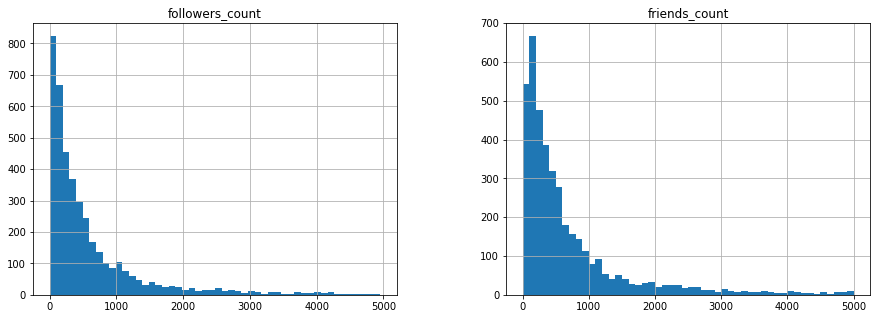

In [14]:
max_count = 5000

df.loc[(df.friends_count<max_count) & (df.followers_count<max_count), ['friends_count', 'followers_count']].hist(bins=50, figsize=(15,5))

In [15]:
test_df = df[(400<df.friends_count) & (df.friends_count<=500)]
test_df = test_df.reset_index(drop=True)

In [16]:
len(test_df)

321

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1516f65550>,
      dtype=object)

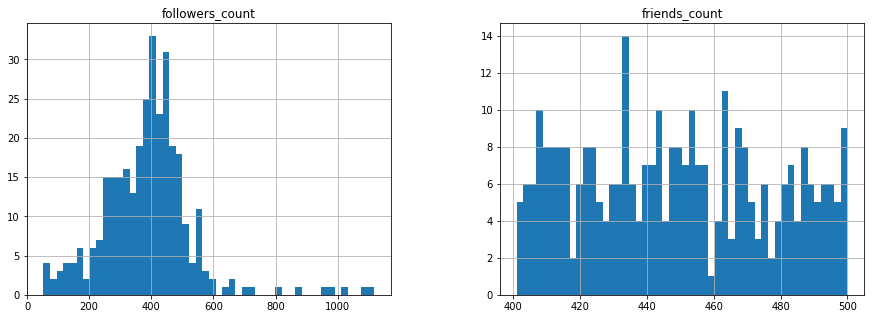

In [17]:
test_df.loc[:, ['friends_count', 'followers_count']].hist(bins=50, figsize=(15,5))

In [18]:
from db import psql_save
psql = psql_save()

In [20]:
value_list = []
test_df = test_df[170:]
test_df = test_df.reset_index(drop=True)

for i in tqdm(range(11, len(test_df))):
    user_id = test_df['user_id'][i]
    screen_name = test_df['screen_name'][i]
    
    friends_ids = tw.getFriendIds(screen_name)
    str_friends_ids = ','.join(map(str, friends_ids))
    
    value_list.append([user_id, screen_name, str_friends_ids])
    time.sleep(60*random.uniform(0.5,1.5))

    if i%10==0 and i!=0:
        temp = ["(%d,'%s','%s')" % (v[0], v[1], v[2]) for v in value_list]
        temp = ','.join(temp)
        try:
            psql.insert_friends(value_list=temp)
        except:
            pass
        value_list.clear()
        time.sleep(15*60*random.uniform(0.5,1.5))


  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 